In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
plt.rcParams["svg.fonttype"]= "none"

In [ ]:
study_dir = "path/to/cell_type/information"

In [ ]:
def process_data_subclasses(df, subclass1, subclass2):
    nouveau_df = df.stack().reset_index()
    nouveau_df.columns = ['CT_1', 'CT_2', 'Fold_change']
    
        
    mask = ~nouveau_df['CT_1'].str.contains('L6 IT Car3', case=False) & \
           ~nouveau_df['CT_2'].str.contains('L6 IT Car3', case=False)

    nouveau_df = nouveau_df[mask]
    
    nouveau_df.reset_index(drop=True, inplace=True)
    
    # Keep only the pairs involving subclass1 and subclass 2
    subclass_classes_1 = subclass_dict[subclass1]
    subclass_classes_2 = subclass_dict[subclass2]
    
    subclass_pairs = nouveau_df[
        nouveau_df['CT_2'].isin(subclass_classes_1) &
        nouveau_df['CT_1'].isin(subclass_classes_2)
    ].copy()
    print(subclass_pairs)
 
    # Create an unordered pair key: (A,B) and (B,A) will map to the same key
    subclass_pairs["pair_key"] = subclass_pairs.apply(
        lambda r: tuple(sorted((r["CT_1"], r["CT_2"]))),
        axis=1
    )

    # Remove duplicates where the same unordered pair appears twice (e.g. VIP-Sncg == Sncg-VIP)
    # Keep the first occurrence only.
    subclass_pairs = subclass_pairs.drop_duplicates(subset="pair_key", keep="first").drop(columns="pair_key")
    print("After filtering", subclass_pairs)

    # Create a readable pair label
    subclass_pairs["pair"] = subclass_pairs["CT_1"] + "_" + subclass_pairs["CT_2"]

    return subclass_pairs

In [ ]:
## Categories of inhibitory / IT / Oligo pairs classes:
inhibitory_classes = ["Pvalb","Sst","Vip", "Lamp5", "Lamp5 Lhx6", "Sncg", "Chandelier", "Pax6"]
inhibitory_classes_no_VIP = ["Pvalb","Sst", "Lamp5", "Lamp5 Lhx6", "Chandelier", "Pax6"]
excitatory_classes = ["L2/3 IT", "L4 IT", "L5 IT", "L5 ET", "L5/6 NP", "L6b", "L6 CT", "L6 IT"]
upper_classes = ["L2/3 IT"]
deeper_classes = ["L4 IT", "L5 IT", "L5 ET", "L5/6 NP", "L6b", "L6 CT", "L6 IT"]
glial_classes = ["OPC", "Microglia-PVM", "Oligodendrocyte", "Astrocyte"]
Lamp5_classes = ["Lamp5", "Lamp5 Lhx6"]
PV_classes = ["Pvalb", "Chandelier"]
SST_classes = ["Sst"]
Pax6_classes = ["Pax6"]
Vip_classes = ["Vip", "Sncg"]
CGE_classes = ["Lamp5", "Vip", "Pax6", "Sncg"]
MGE_classes = ["Sst", "Pvalb", "Lamp5 Lhx6", "Chandelier"]

In [ ]:
## CORRELATION CCI BASED ON subclasses (IT, inhibitory, glial)

results = []
list_samples = ["aSTG1", "aSTG2", "aSTG3", "pSTG1", "pSTG3", "pSTG4", "pSTG5"]
specie = "human" # macaque

## ANALYSES BY SUBCLASSES SUBSETS:
subclass_levels = ["inhibitory", "glial", "excitatory"]
subclass1 = "PV" 
subclass2 = "inhibitory"

# Mapping of the subclasses to their classes:
subclass_dict = {
    "inhibitory": inhibitory_classes,
    "excitatory": excitatory_classes,
    "upper": upper_classes,
    "deeper": deeper_classes,
    "glial": glial_classes,
    "Lamp5": Lamp5_classes,
    "PV": PV_classes,
    "Sst": SST_classes,
    "Vip": Vip_classes,
    "inhibitory_no_VIP": inhibitory_classes_no_VIP,
    "CGE": CGE_classes,
    "MGE": MGE_classes, 
}


for sample_1 in list_samples:
    for sample_2 in list_samples:
            
            print(sample_1, sample_2)
            
            # Step 1: Load fold change data (upper layer)
            file_1 = pd.read_csv(f"{study_dir}/Fold_changes/{sample_1}/fold_change_upper.tsv", sep="\t")
            file_2 = pd.read_csv(f"{study_dir}/Fold_changes/{sample_2}/fold_change_upper.tsv", sep="\t")

            # Step 2: Transform data and remove duplicates
            nouveau_df_1 = process_data_subclasses(file_1, subclass1, subclass2)
            nouveau_df_2 = process_data_subclasses(file_2, subclass1, subclass2)

            # Step 3: Merge and Compute Pearson correlation for the Upper layers:
            merged = pd.merge(nouveau_df_1[['pair', 'Fold_change']], nouveau_df_2[['pair', 'Fold_change']], how='outer', on='pair', suffixes=('_ant', '_post'))
            print("merged non sorted:", merged)

            merged = merged[(merged["Fold_change_1"] > -1) | (merged["Fold_change_2"] > -1)]
            print("merged sorted:", merged)
            
            merged.fillna(0, inplace=True)
            if merged.shape[0] >= 2:
                correlation, p_value = pearsonr(merged['Fold_change_1'], merged['Fold_change_2'])
            else: 
                correlation, p_value = np.nan, np.nan

            # Step 4: Store results:
            results.append({
                'sample_ant': sample_1,
                'sample_post': sample_2,
                'correlation': correlation,
                'p_value': p_value,
                'nb_values': merged.shape[0],
                'annot_value': f'{correlation:.2f}{np.where(p_value < 0.05, "*", "")}'
            })
            
            
results_df = pd.DataFrame(results)
print(results_df)

aSTG1 aSTG1
      Nom_ligne Nom_colonne  Fold_change
21   Chandelier       Pvalb    -1.000000
57        Lamp5  Chandelier    -1.000000
65        Lamp5       Pvalb    -0.294781
71   Lamp5 Lhx6  Chandelier    -1.000000
78   Lamp5 Lhx6       Pvalb    -0.119718
123       Pvalb  Chandelier    -1.000000
131       Pvalb       Pvalb     2.164557
147         Sst  Chandelier    -1.000000
155         Sst       Pvalb     0.238390
161         Vip  Chandelier    -1.000000
169         Vip       Pvalb    -0.493799
After filtering       Nom_ligne Nom_colonne  Fold_change
21   Chandelier       Pvalb    -1.000000
57        Lamp5  Chandelier    -1.000000
65        Lamp5       Pvalb    -0.294781
71   Lamp5 Lhx6  Chandelier    -1.000000
78   Lamp5 Lhx6       Pvalb    -0.119718
131       Pvalb       Pvalb     2.164557
147         Sst  Chandelier    -1.000000
155         Sst       Pvalb     0.238390
161         Vip  Chandelier    -1.000000
169         Vip       Pvalb    -0.493799
      Nom_ligne Nom_colonne  

(7, 7)
sample_post     aSTG1     aSTG2     aSTG3     pSTG1     pSTG3     pSTG4  \
sample_ant                                                                
aSTG1        1.000000  0.883919  0.963631  0.546639  0.958880  0.952675   
aSTG2        0.883919  1.000000  0.954062  0.592360  0.940130  0.954902   
aSTG3        0.963631  0.954062  1.000000  0.693745  0.995243  0.968826   
pSTG1        0.546639  0.592360  0.693745  1.000000  0.670593  0.706058   
pSTG3        0.958880  0.940130  0.995243  0.670593  1.000000  0.987128   
pSTG4        0.952675  0.954902  0.968826  0.706058  0.987128  1.000000   
pSTG5        0.921554  0.909742  0.983355  0.656604  0.987746  0.964174   

sample_post     pSTG5  
sample_ant             
aSTG1        0.921554  
aSTG2        0.909742  
aSTG3        0.983355  
pSTG1        0.656604  
pSTG3        0.987746  
pSTG4        0.964174  
pSTG5        1.000000  
(7, 7)
sample_post  aSTG1  aSTG2  aSTG3  pSTG1  pSTG3  pSTG4  pSTG5
sample_ant                       

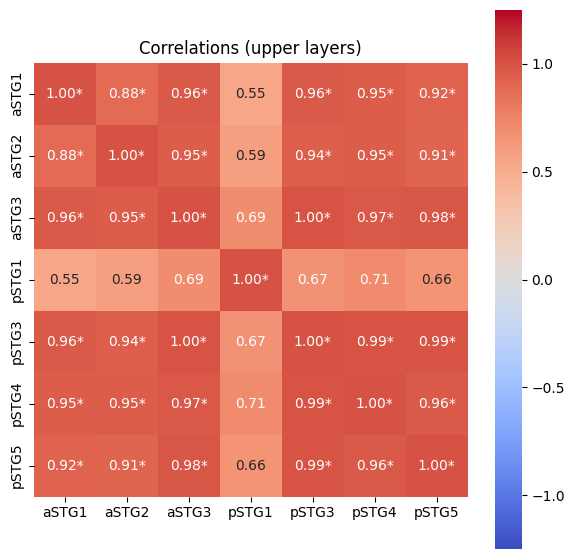

In [ ]:
## Heatmap per subclass: 

cmap='coolwarm'

# Heatmap of correlation for upper layers
heatmap = pd.pivot_table(results_df, values='correlation', index='sample_ant', columns='sample_post')
heatmap_bis = pd.pivot(results_df, values='annot_value', index='sample_ant', columns='sample_post')
print(heatmap.shape)
print(heatmap)

print(heatmap_bis.shape)
print(heatmap_bis)


plt.figure(figsize=(7,7))
sns.heatmap(heatmap, annot = heatmap_bis, cmap=cmap, square=True, vmin=-1.25, vmax=1.25, fmt = "")
plt.title('Correlations (upper layers)')

plt.xlabel(None)
plt.ylabel(None)
plt.show()